In [1]:
from collections import OrderedDict
import re
import os, sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

import scienceplots
plt.style.use(['science', 'no-latex', 'light'])

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models_v2_only_metrics/"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

run_id                      task  \
0  5abe7c74-9c58-4f59-81ab-e7c7f5be3ed9  linear_regression_skewed   
1  3da3e8d4-1b5d-4c59-a4c4-5a416410bf55  linear_regression_skewed   
2  e78c934f-5106-4f22-95f9-6951bf5cca39  linear_regression_skewed   
3  0fa97d7b-3a68-4f19-a955-f205d6bdaca8  linear_regression_skewed   
4  3f82892f-d8d7-499c-bb6b-123c61fd11f6  linear_regression_skewed   
5  72161573-8e3a-4c73-9589-0941e2882d08  linear_regression_skewed   

                            model kwargs  num_tasks  num_examples  n_dims  \
0  skewed_linear_regression_mamba                -1            -1      20   
1  skewed_linear_regression_mamba                -1            -1      20   
2  skewed_linear_regression_mamba                -1            -1      20   
3                     Transformer                -1            -1      20   
4                     Transformer                -1            -1      20   
5                     Transformer                -1            -1      20   

   n_layer  n_head                           run_name  
0       24       0     skewed_linear_regression_mamba  
1       24       0     skewed_linear_regression_mamba  
2       24       0     skewed_linear_regression_mamba  
3       12       8  skewed_linear_regression_standard  
4       12       8  skewed_linear_regression_standard  
5       12       8  skewed_linear_regression_standard

# Plot pre-computed metrics

skewed_linear_regression_mamba 5abe7c74-9c58-4f59-81ab-e7c7f5be3ed9


100%|██████████| 15/15 [00:00<00:00, 305410.49it/s]

skewed_linear_regression_mamba 3da3e8d4-1b5d-4c59-a4c4-5a416410bf55



100%|██████████| 15/15 [00:00<00:00, 325982.18it/s]


skewed_linear_regression_mamba e78c934f-5106-4f22-95f9-6951bf5cca39


100%|██████████| 15/15 [00:00<00:00, 308404.71it/s]


skewed_linear_regression_standard 0fa97d7b-3a68-4f19-a955-f205d6bdaca8


100%|██████████| 15/15 [00:00<00:00, 55382.54it/s]


skewed_linear_regression_standard 3f82892f-d8d7-499c-bb6b-123c61fd11f6


100%|██████████| 15/15 [00:00<00:00, 72149.72it/s]


skewed_linear_regression_standard 72161573-8e3a-4c73-9589-0941e2882d08


100%|██████████| 15/15 [00:00<00:00, 292625.86it/s]


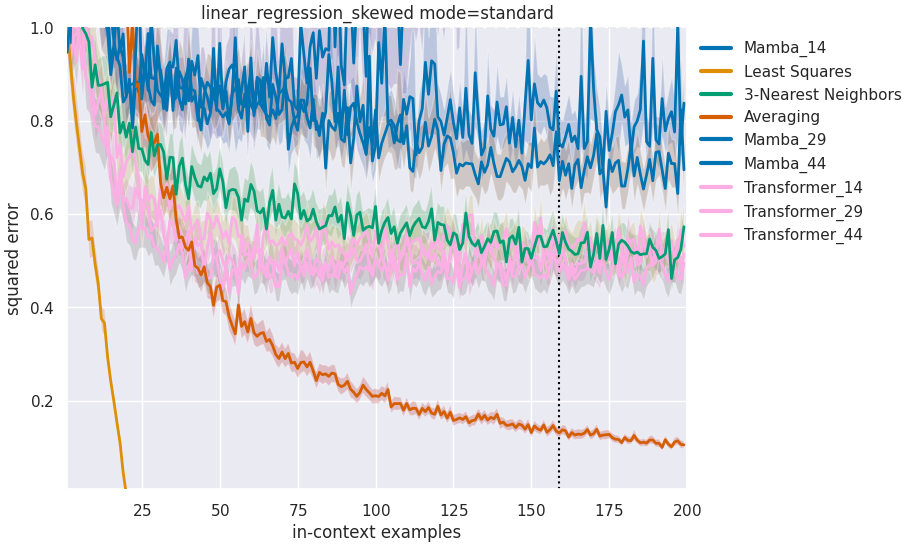

In [11]:
 # these are normally precomputed at the end of training
for task in (
    "linear_regression_skewed",
    # "linear_regression",
    # "sparse_linear_regression",
    # "decision_tree",
    # "relu_2nn_regression",
):

    for _, r in df.iterrows():
        if r.task==task:
            run_path = os.path.join(run_dir, r.task, r.run_id)
            _, conf = get_model_from_run(run_path, only_conf=True)
            break

    xlim = 200
    # xlim = 100
    # xlim = None
    # xlim = 500

    def valid_row(r):
        return r.task ==task

    model_dict = dict()
    def rename_model(x, r):    
        name = x if 'mamba' not in x else 'Mamba'
        if name in model_dict.keys():
            model_dict[name] +=1
            return f"{name}_{model_dict[name]}"
        else:
            model_dict[name] = 0
            return name
    
    eval_name_dict = dict()
    def rename_eval(eval_name, r):
        if eval_name in eval_name_dict:
            eval_name_dict[eval_name] +=1
            return f"{eval_name}_{eval_name_dict[eval_name]}"
        else:
            eval_name_dict[eval_name] = 0
            return eval_name

    metrics = collect_results(run_dir, df, valid_row=valid_row, rename_eval=None, rename_model=rename_model,
                              no_recompute=True, xlim=xlim)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims
    n_train_points = conf.training.curriculum.points.end



    # models = relevant_model_names[task].copy()
    # models.remove('Mamba')
    # models.remove('S4')
    # models.remove('Transformer')
    

    fig, ax = basic_plot(metrics["standard"], size=(3, 4), models=None, title=f"{task} mode=standard", n_train_points=n_train_points,
               size_mult=2.)
    ax.set_xlim(1, 200)
    if task=='sparse_linear_regression':
        ax.set_ylim(1e-4, 1.25)
    elif task=='decision_tree':
        ax.set_ylim(2e-3, 5.25)
    elif task=='relu_2nn_regression':
        ax.set_ylim(1e-1, 5.25)
    elif task=='linear_regression_skewed':
        ax.set_xlim(1, 200)
        ax.set_ylim(1e-2, 1)
    
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # plt.savefig(f"../imgs/no_pos/{task}.png")
    plt.show()

In [12]:
metrics.keys()

dict_keys(['linear_regression', 'standard'])

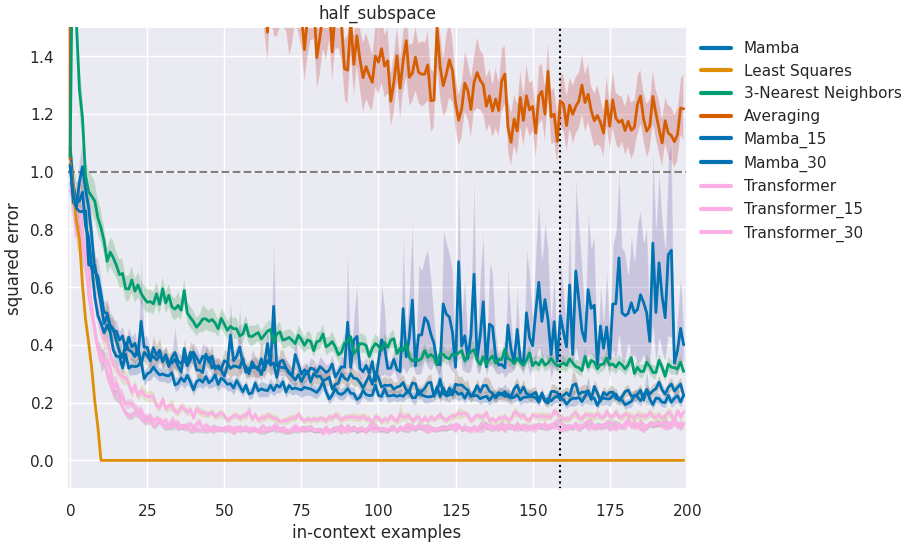

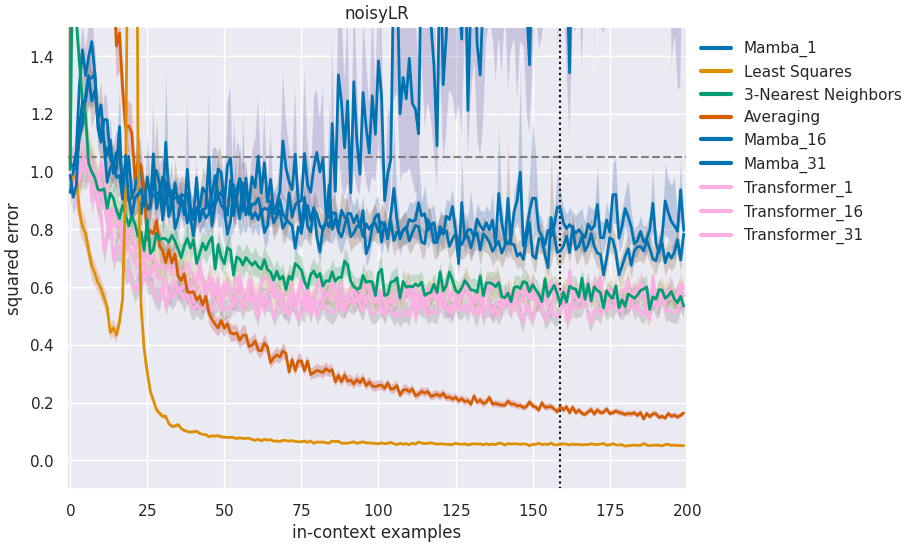

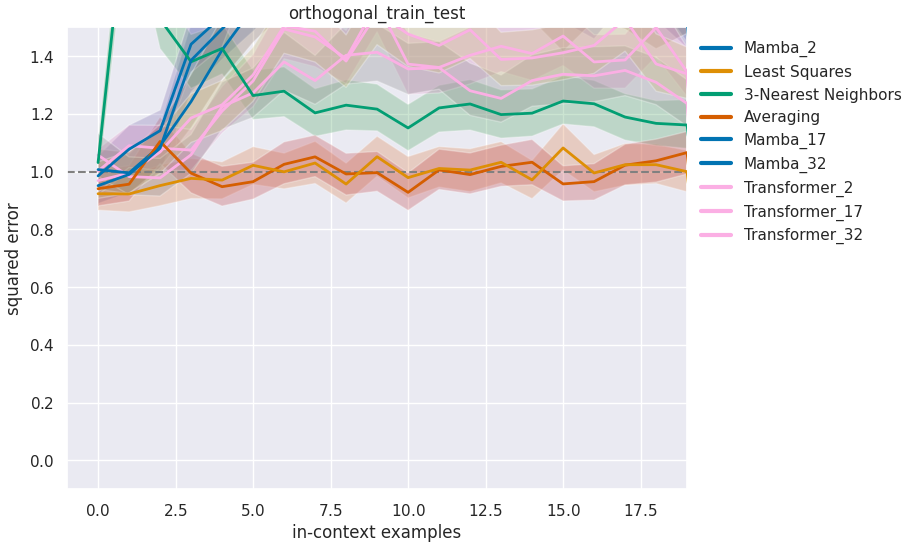

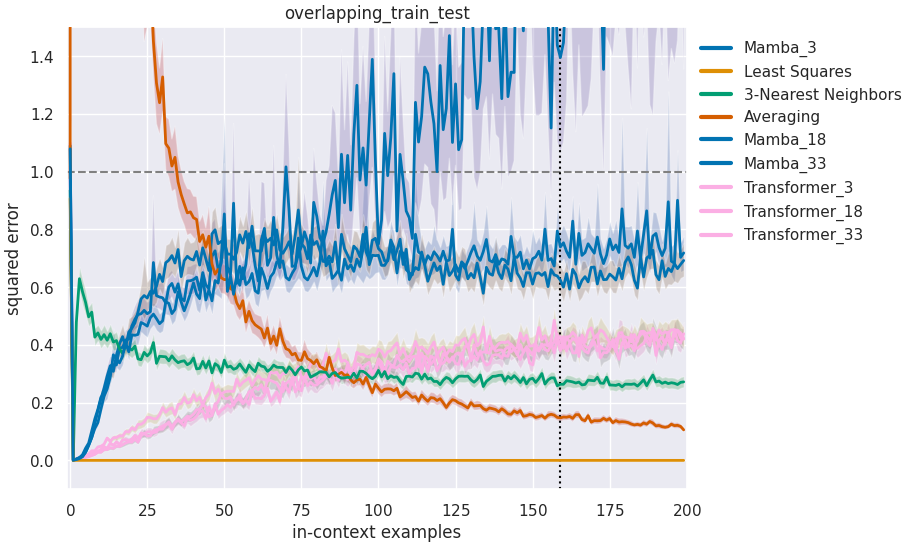

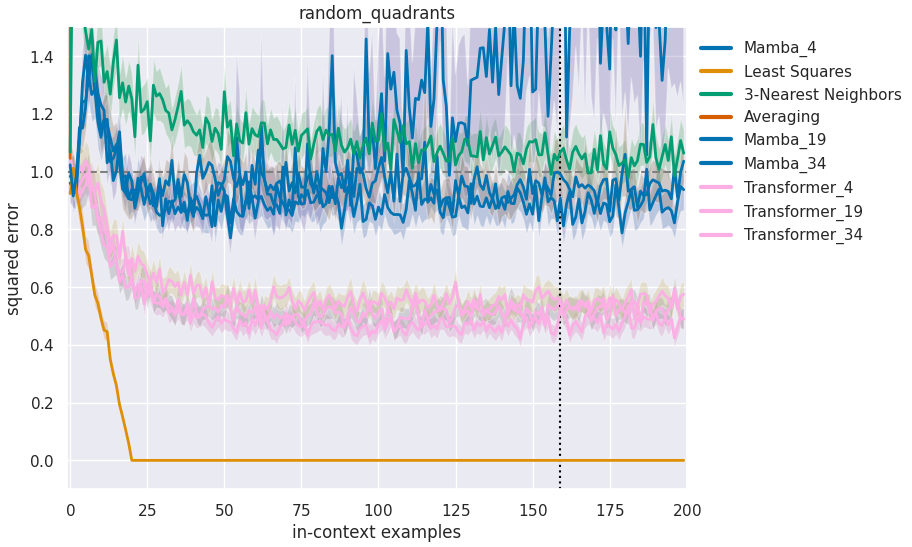

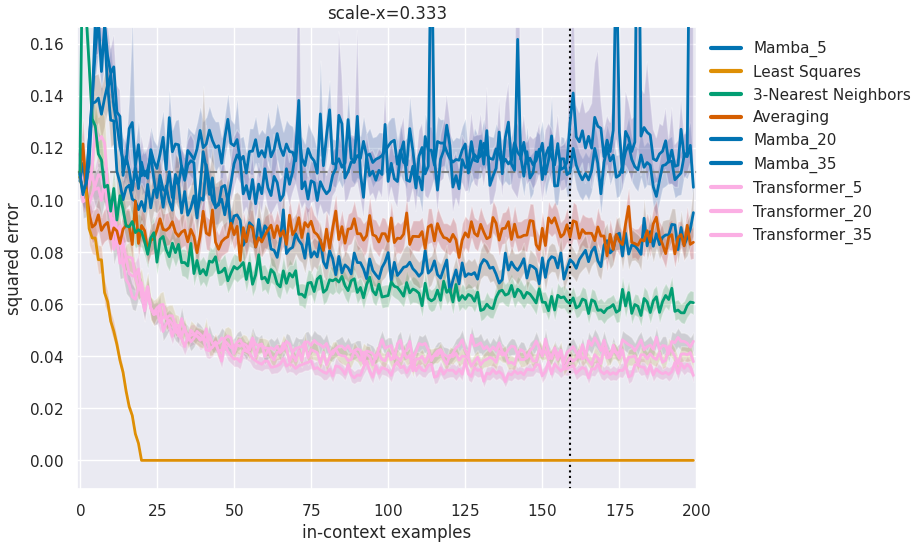

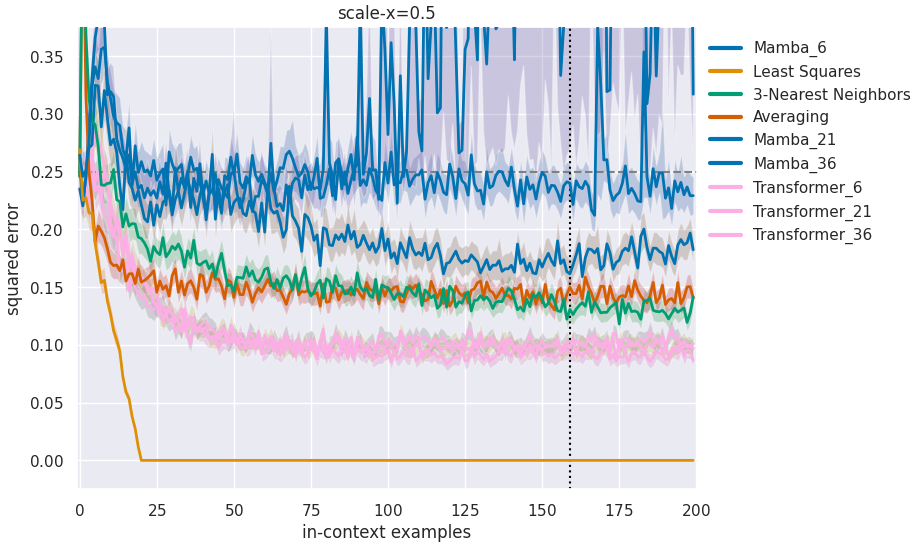

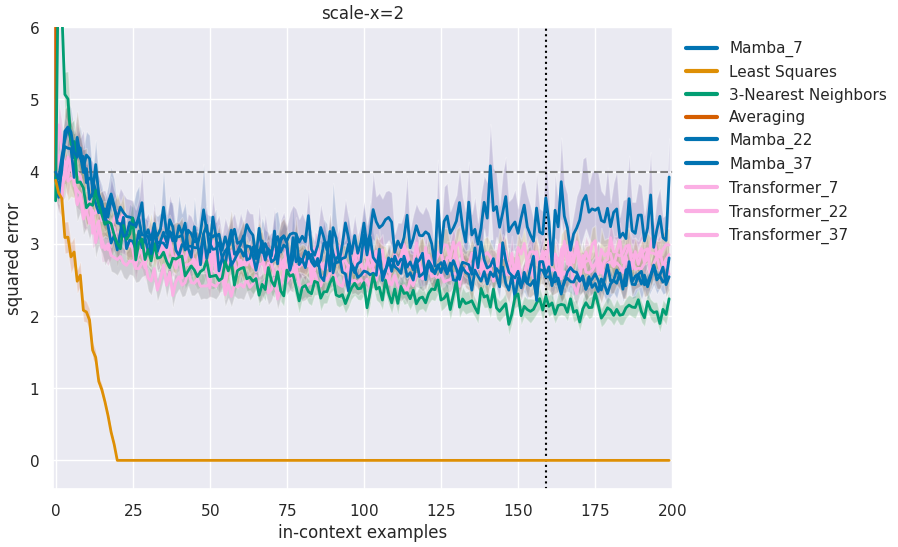

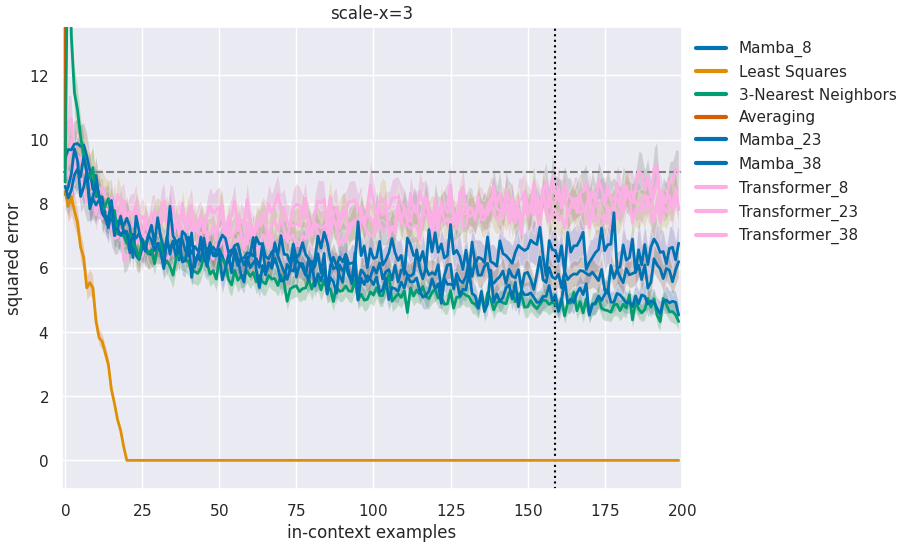

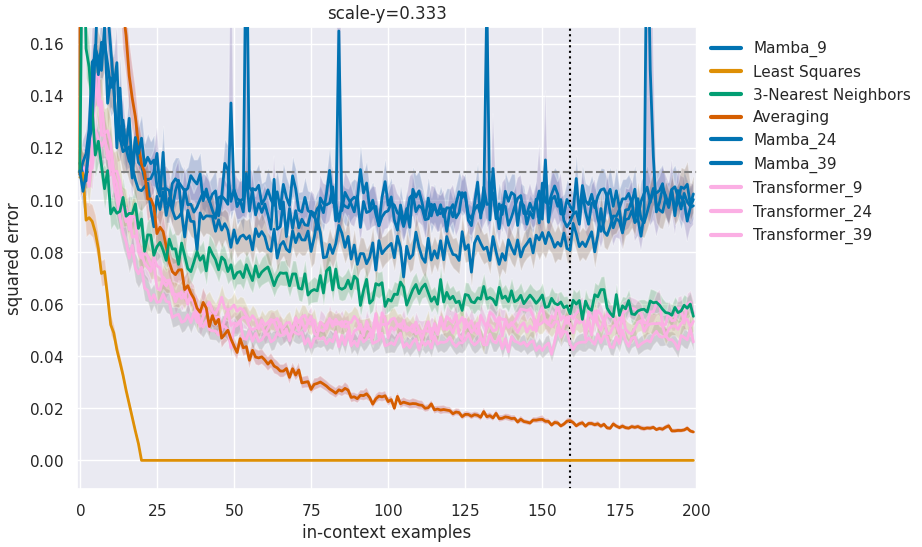

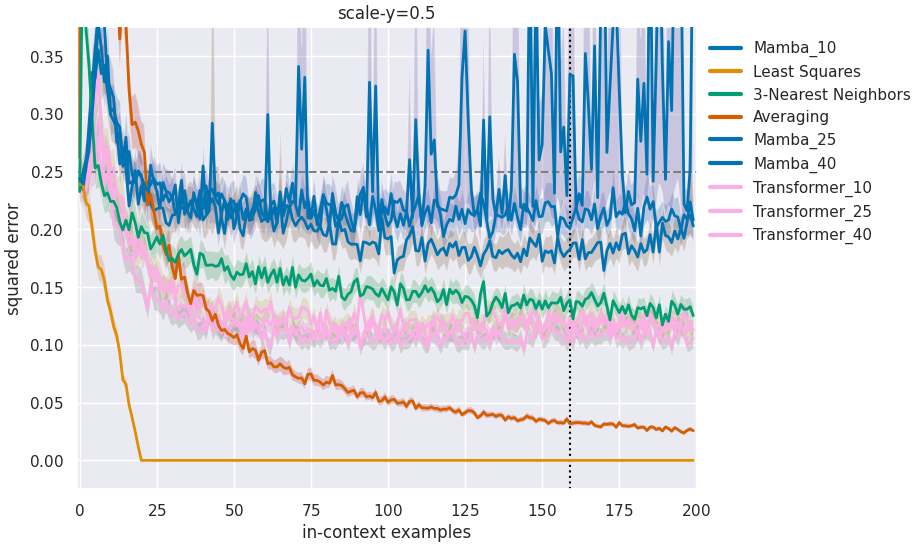

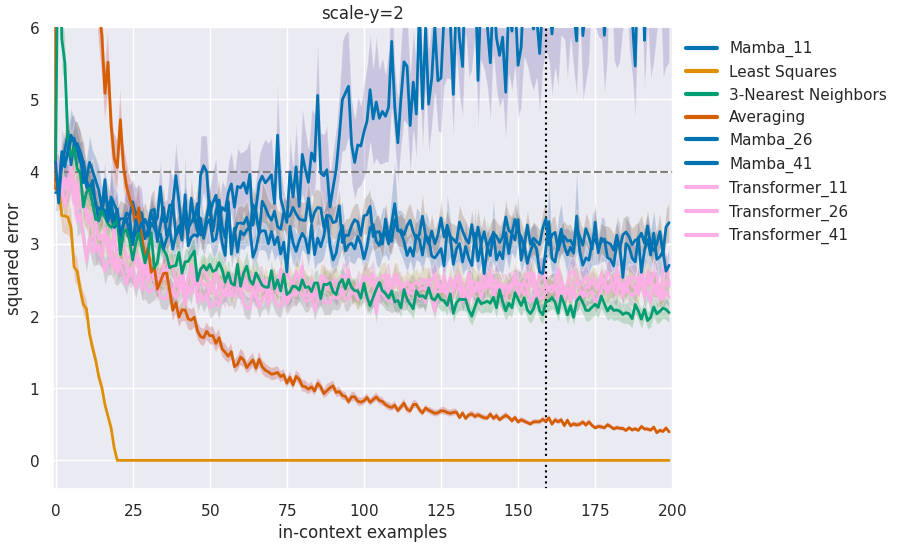

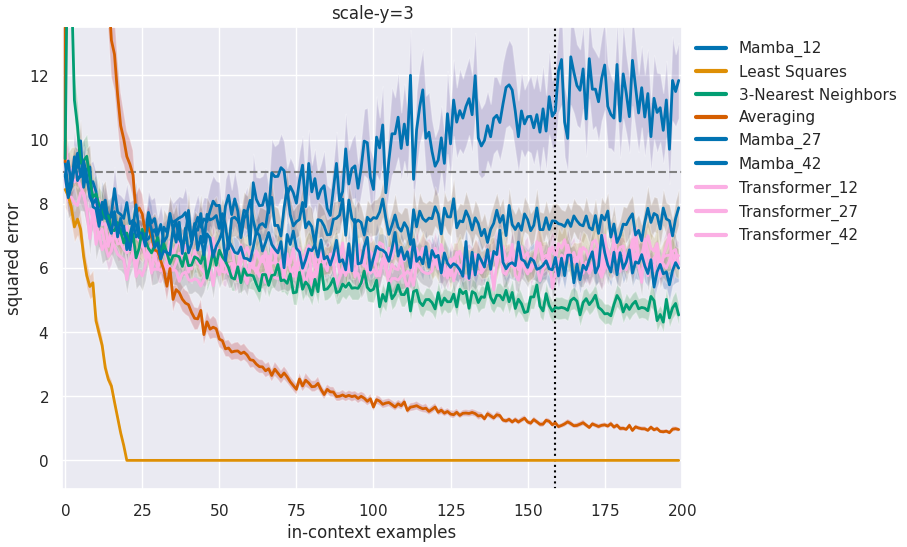

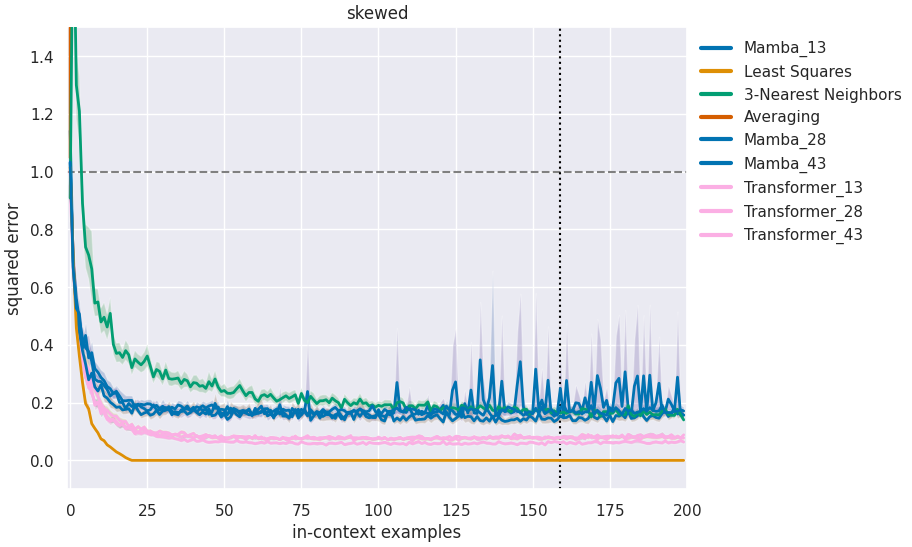

In [15]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, size=(3, 4), models=None, trivial=trivial * scale, size_mult=2., n_train_points=n_train_points)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)
    # plt.savefig(f"../imgs/no_pos/out_of_dist/{name}.png")
    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [21]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [22]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [23]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [24]:
with torch.no_grad():
    pred = model(xs, ys)

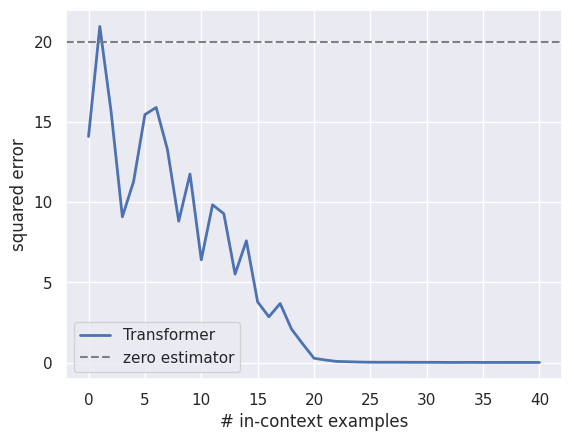

In [25]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [26]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

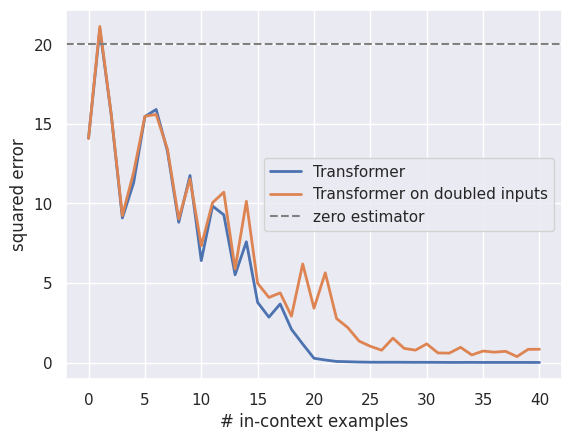

In [27]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.